# PoliTwit

## Examining political speech on social media

### Tyler Nevell and Kyle Staub

### GitHub link: https://github.com/KStaub/politwit

#### Dataset

* Origin: 
    * Crowdflower Data for Everyone dataset: https://www.crowdflower.com/data-for-everyone/
    * https://www.kaggle.com/crowdflower/political-social-media-posts/data
* Meta-data:
    * _unit_id: a unique id for the message
    * _golden: always FALSE; (presumably whether the message was in Crowdflower's gold standard)
    * _unit_state: always "finalized"
    * _trusted_judgments: the number of trusted human judgments that were entered for this message; an integer between 1 and 3
    * _last_judgment_at: when the final judgment was collected
    * audience: one of national or constituency
    * audience:confidence: a measure of confidence in the audience judgment; a float between 0.5 and 1
    * bias: one of neutral or partisan
    * bias:confidence: a measure of confidence in the bias judgment; a float between 0.5 and 1
    * message: the aim of the message. one of: 
        * attack: the message attacks another politician 
        * constituency: the message discusses the politician's constituency 
        * information: an informational message about news in government or the wider U.S. 
        * media: a message about interaction with the media 
        * mobilization: a message intended to mobilize supporters 
        * other: a catch-all category for messages that don't fit into the other 
        * personal: a personal message, usually expressing sympathy, support or condolences, or other personal opinions 
        * policy: a message about political policy 
        * support: a message of political support
    * message:confidence: a measure of confidence in the message judgment; a float between 0.5 and 1
    * orig__golden: always empty; presumably whether some portion of the message was in the gold standard
    * audience_gold: always empty; presumably whether the audience response was in the gold standard
    * bias_gold: always empty; presumably whether the bias response was in the gold standard
    * bioid: a unique id for the politician
    * embed: HTML code to embed this message
    * id: unique id for the message WITHIN whichever social media site it was pulled from
    * label: a string of the form "From: firstname lastname (position from state)"
    * message_gold: always blank; presumably whether the message response was in the gold standard
    * source: where the message was posted; one of "facebook" or "twitter"
    * text: the text of the message
    
#### Goal

Seeking to predict relationships between certain words and certain message types as determined by qualified human assessors. To do so, we will apply both a Naive Bayes (NB) Classifier and a Support Vector Machine (SVM).  

- <b>Hypothesis \#1</b>: Our SVM classifier will be a better predictor than our NB classifier.
- <b>Hypothesis \#2</b>: Certain words will be highly correlated with certain messages. For instance, we anticipate the following text/message pairs to be highly correlated:
    * Obama > attack
    * veterans > support
    * proud > support
    * bill > policy
    * ICYMI > media

#### Data provenance and trustworthiness considerations

This dataset contains 5000 entries of tweets or Facebook posts by members of Congress, that are labelled by "contributors". Contributors from Crowdflower (https://www.crowdflower.com/data-for-everyone-full-library/#!/) go through each post and classify its contents on the basis of the audience, bias, and message components listed in the metadata. It is an interesting dataset because it contains confidence measures, but is also subject to persuasion by the contributors themselves, pointing to a central problem in trusting human labeled datasets. We believe that this dataset will largely conform with the average person's intuitions about the labelling of tweets according to a binary statement of bias, or a categorical attribution of message type. 

#### Data cleaning

For the purposes of our scope, many of the columns listed in the metadata are superfluous. We will be using only four columns: Message, Bias, Label, and Text. To be fed into our classifiers, text will be tokenized into a numeric representation of the text, which we can use to predict a certain message type as one of: 
* attack
* constituency
* information
* media
* mobilization 
* other 
* personal 
* policy 
* support
       


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from collections import Counter
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
from textblob.classifiers import DecisionTreeClassifier

In [2]:
import scipy.stats
import sklearn.linear_model
import sklearn.discriminant_analysis
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.neighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.pipeline import Pipeline


In [3]:
twt = pd.read_csv('political_statements_raw.csv', encoding='utf8')

In [4]:
# Removing columns irrelevant to the current analysis
tdf = twt.drop(['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'audience', \
                'audience:confidence', 'bias:confidence', 'message:confidence', 'orig__golden', 'audience_gold', \
               'bias_gold', 'bioid', 'embed', 'id', 'message_gold', 'source'], axis=1)

# Creating a new column, wordvec, containing a vector of all words in the text field
tdf['wordvec'] = [i for i in tdf.text.str.split(" ")]

# Converting the bias and message fields to categorical
tdf.bias = pd.Categorical(tdf.bias)
tdf.message = pd.Categorical(tdf.message)

# Taking an initial look at our dataframe
tdf.head()

,bias,message,label,text,wordvec
0,partisan,policy,From: C.A. Dutch Ruppersberger (Representative...,.@DeltaDiva3 One idea is to allow students to ...,"[.@DeltaDiva3, One, idea, is, to, allow, stude..."
1,neutral,media,From: Jeb Hensarling (Representative from Texas),Joining the @MarkDavis show on @660KSKY this m...,"[Joining, the, @MarkDavis, show, on, @660KSKY,..."
2,neutral,information,From: Cory Booker (Senator from New Jersey),RT @HeraldNews See photos from the ‰Û÷Run With...,"[RT, @HeraldNews, See, photos, from, the, ‰Û÷R..."
3,neutral,support,From: John McCain (Senator from Arizona),Headed to #Scottsdale for event honoring Marsh...,"[Headed, to, #Scottsdale, for, event, honoring..."
4,neutral,information,From: JosÌ© Serrano (Representative from New Y...,Today at 10:30 ribbon cutting ceremony at @sou...,"[Today, at, 10:30, ribbon, cutting, ceremony, ..."


In [5]:
# What are all of the unique words in wordvec?
allwords = Counter()
tdf.wordvec.apply(allwords.update)
print('150 most common words:\n', allwords.most_common(50))
print('\n\n')
print('50 of the least common words:\n', allwords.most_common()[-250:-200])

150 most common words:
 [('the', 6979), ('to', 5844), ('and', 3604), ('of', 3360), ('in', 2712), ('a', 2384), ('', 2250), ('for', 2044), ('on', 1657), ('I', 1407), ('is', 1356), ('with', 1098), ('that', 1096), ('our', 1061), ('at', 979), ('this', 920), ('my', 740), ('be', 707), ('will', 689), ('are', 669), ('The', 660), ('you', 659), ('from', 650), ('by', 604), ('have', 569), ('about', 548), ('we', 531), ('their', 508), ('as', 452), ('was', 446), ('who', 428), ('it', 411), ('&amp;', 409), ('more', 408), ('House', 397), ('has', 379), ('an', 362), ('can', 354), ('all', 335), ('your', 334), ('not', 317), ('This', 296), ('his', 293), ('today', 291), ('We', 274), ('out', 253), ('they', 249), ('-', 247), ('or', 238), ('great', 229)]



50 of the least common words:
 [('"Public', 1), ('Servants', 1), ('Dinner."', 1), ('Parenting', 1), ('Galveston', 1), ('‰ÛÏEvery', 1), ('child,', 1), ('aborted,', 1), ('Lord,', 1), ('birth,', 1), ('born,', 1), ('rejection', 1), ('world.‰Û\x9d-', 1), ('interest

It appears that there are some very clear outliers in this data, as you would suspect. The grammatical connective words ('the', 'to', 'and', etc.) are extremely common. Similarly, there are some outright unique words, largely due to an one of an encoding issue, hyperlink, etc. We intend to monitor this skew in the word frequency data for possible correction in the future. 

Further quantitative analysis isn't possible given the nature of our data. Because it is a set of discrete features (words in our tweets) attempting to classify a set of categorical resuts (message types), there is not a coherent distribution function that maps to our data. Similarly, correlation coefficients and r-squared values are inappropriate for describing our data. Rather, a frequency analysis (below) and an identification of the model's informative featureset (analogous to correlation coefficients) is more appropriate. 

#### Testing our Correlation Hypotheses

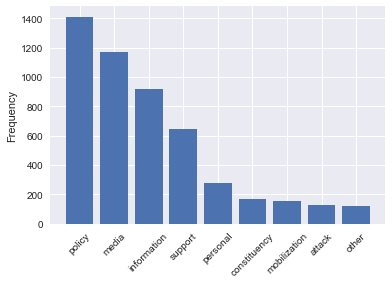

In [6]:
x = tdf.message.unique()
y = tdf.message.value_counts()
plt.bar(x, y);
plt.xticks(rotation=45);
plt.ylabel('Frequency');

This plot shows that we may have some problem due the heavy skew towards a few message types. Our hypotheses rely somewhat on an assumption of uniformity in the occurance of the different message types across our dataset. Due to this skew, our predicted messages for our selected words may be unlikely or may have a bias towards the high frequency categories. 

In [7]:
print("All messages:\n",tdf.message.describe())
print("\nAll biases:\n",tdf.bias.describe())


print("\nFor tweets containing the word 'Obama':\n",tdf.message[tdf.text.str.contains("Obama")].describe())
print("\nFor tweets containing the word 'veterans':\n",tdf.message[tdf.text.str.contains("veterans")].describe())
print("\nFor tweets containing the word 'proud':\n",tdf.message[tdf.text.str.contains("proud")].describe())
print("\nFor tweets containing the word 'bill':\n",tdf.message[tdf.text.str.contains("bill")].describe())
print("\nFor tweets containing the word 'ICYMI':\n",tdf.message[tdf.text.str.contains("ICYMI")].describe())

All messages:
 count       5000
unique         9
top       policy
freq        1411
Name: message, dtype: object

All biases:
 count        5000
unique          2
top       neutral
freq         3689
Name: bias, dtype: object

For tweets containing the word 'Obama':
 count        405
unique         9
top       policy
freq         185
Name: message, dtype: object

For tweets containing the word 'veterans':
 count        118
unique         9
top       policy
freq          37
Name: message, dtype: object

For tweets containing the word 'proud':
 count          112
unique           9
top       personal
freq            43
Name: message, dtype: object

For tweets containing the word 'bill':
 count        320
unique         9
top       policy
freq         170
Name: message, dtype: object

For tweets containing the word 'ICYMI':
 count         71
unique         6
top       policy
freq          23
Name: message, dtype: object


These results show that our hypotheses are largely incorrect. Concerning our example word, 'bill', our hypothesis was correct, but it appears that it may have been correct for the wrong reason. The most frequent message type, "policy", occurs much more frequently than we assumed in our hypotheses, rendering Hypothesis \#2 incorrect.

Furthermore, for any prediction about the relationship between certains words and their message types, those predictions are more likely to be accurate if they predict the message as policy, media, or information. This type of data skew is something that machine learning models are susceptible to replicating in making the laziest prediction. We will have to keep an eye on that as we apply our models. 

#### Transforming the Text and Splitting the Data

In order for our classifiers to process the string data of our textyual fields, they need to be tokenized to numerical vectors. This process is different for our target and our data. For our target, because it is a categorical variable, we need to encode those categories into integers using a Label Encoder. For our data, because it is a set of discrete strings, we need to tokenize them on the basis of the frequency of their occurance in the corpus of text. 

After transforming our target and data, we need to split our training and testing data. We will use a standard test size of 33% of the dataset across our models, as this value seems to be semi-optimal for increasing our model's accuracy. With smaller test sizes, you may get higher point-accuracies for certain runs, purely due to coincidence.

In [8]:
# Defining our label encoder
le = sklearn.preprocessing.LabelEncoder()

In [9]:
import warnings; warnings.simplefilter('ignore')
# Our data is the text of the tweet, and the target is the assigned message
X, y = tdf.text, tdf.message
le.fit(y)
y = le.transform(y)

# Tokenizing our sentences in order to pass them in as numerical values to our classifier
count_vect = CountVectorizer()
X_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
X = X_tfidf

# Splitting our data into training and testing sets 
trainX, testX, trainy, testy = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

# Label encoding our target message
print("Our target categories are: ",np.unique(y))
print("which correspond to the following message types: ",np.unique(le.inverse_transform(y)))


Our target categories are:  [0 1 2 3 4 5 6 7 8]
which correspond to the following message types:  ['attack' 'constituency' 'information' 'media' 'mobilization' 'other'
 'personal' 'policy' 'support']


#### Multinomial Naive Bayes Classification

Multinomial Naive Bayes is the first step in working with text data. It is a supervised learning technique that uses Bayes Theorem with the assumption of independence between all of the features. We are using it here to classify certain tweets as a certain message type. We do the standard fit/predict steps to obtain our model and predictor. 

In [10]:
# Initializing our model
mnnb = MultinomialNB()
# Fitting our NB classifier
classifier = mnnb.fit(trainX, trainy)
# Creating a predictor for our test tweets
predictor = classifier.predict(testX)

In [11]:
warnings.simplefilter('ignore')
print("Classification report for Multinomial NB classifier:\n\n",metrics.classification_report(testy, predictor, target_names=le.inverse_transform(y)))
print("Confusion matrix for Multinomial NB classifier:\n\n",metrics.confusion_matrix(testy, predictor))

Classification report for Multinomial NB classifier:

               precision    recall  f1-score   support

      policy       0.00      0.00      0.00        54
       media       0.00      0.00      0.00        66
 information       0.00      0.00      0.00       217
     support       0.00      0.00      0.00        78
 information       0.00      0.00      0.00        38
 information       0.00      0.00      0.00        39
     support       0.52      0.42      0.46       400
      policy       0.34      0.97      0.50       462
 information       0.14      0.00      0.01       296

 avg / total       0.25      0.37      0.25      1650

Confusion matrix for Multinomial NB classifier:

 [[  0   0   0   0   0   0   0  54   0]
 [  0   0   0   0   0   0  21  45   0]
 [  0   0   0   0   0   0  35 181   1]
 [  0   0   0   0   0   0   9  68   1]
 [  0   0   0   0   0   0   6  32   0]
 [  0   0   0   0   0   0   6  33   0]
 [  0   0   0   0   0   0 169 229   2]
 [  0   0   0   0   0   0

In [12]:
print("Overall accuracy of our Multinomial NB predictor is: ",np.mean(predictor == testy))

Overall accuracy of our Multinomial NB predictor is:  0.37393939393939396


Overall, this appears to be a fairly successful model. While the classification report and the confusion matrix do show some serious overfitting to the overrepresented message types, we still achieve a fit that's better than pure chance, as discussed below. While the model is successful, it's confusion matrix shows serious deficiencies in classifying the majority of different messages types, as it takes the safe and lazy approach.

#### Support Vector Machine Classification

In [13]:
# Creating a pipeline
X, y = tdf.text, tdf.message
trainX, testX, trainy, testy = sklearn.model_selection.train_test_split(X, y, test_size=0.33)
tweet_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='squared_loss', penalty='elasticnet',
                                          alpha=1e-3, random_state=42,
                                          max_iter=10, tol=None, 
                                          class_weight='balanced')),
                     ]);

# Fitting our classifier
tweet_clf.fit(trainX, trainy);

In [14]:
# Creating a predictor for our test tweets
predicted = tweet_clf.predict(testX)
print("Overall accuracy of our Mulinomial NB predictor is: ",np.mean(predicted == testy))

Overall accuracy of our Mulinomial NB predictor is:  0.3212121212121212


In [15]:
warnings.simplefilter('ignore')
print("Classification report for SVM classifier:\n\n",metrics.classification_report(testy, predicted))
print("Confusion matrix for SVM classifier:\n\n",metrics.confusion_matrix(testy, predicted))

Classification report for SVM classifier:

               precision    recall  f1-score   support

      attack       0.13      0.33      0.19        58
constituency       0.08      0.19      0.11        52
 information       0.23      0.15      0.19       214
       media       0.28      0.59      0.38        90
mobilization       0.12      0.35      0.18        46
       other       0.10      0.19      0.14        36
    personal       0.50      0.39      0.44       404
      policy       0.47      0.48      0.48       455
     support       0.20      0.06      0.09       295

 avg / total       0.35      0.32      0.32      1650

Confusion matrix for SVM classifier:

 [[ 19   0   4   2   6   3   0  22   2]
 [  3  10   6   5   1   4  11   6   6]
 [ 14  25  33  23  14   7  24  63  11]
 [  1   9   7  53   2   1   6   8   3]
 [  1   4   4   3  16   3   2  11   2]
 [  5   3   3   4   3   7   8   1   2]
 [ 15  41  34  36  26  20 156  54  22]
 [ 69  16  29  31  35   6  32 219  18]
 [ 15  1

#### Analysis of Models and Assessing Hypothesis \#1

In [16]:
runs = 25
accuracies = np.empty(runs)
for i in range(len(accuracies)):
    trainX, testX, trainy, testy = sklearn.model_selection.train_test_split(X, y, test_size=0.33)
    tweet_clf.fit(trainX, trainy);
    pred = tweet_clf.predict(testX)
    accuracies[i] = np.mean(pred == testy)
    
print('For {} runs, our average accuracy is: {}'.format(runs, np.mean(accuracies)))


For 25 runs, our average accuracy is: 0.3185454545454546


For our model to be better than chance, we have to achieve over 0.11 probability of making a correct prediction. If we chose a message at random, due to the skew of our data, the absolute *best* we could do is guess correctly 1 out of 9 times. 

For the afore-run Multinomial NB classifier, we consistently achieved between 0.20 and 0.40 prediction accuracy. This is certainly better than chance, though fairly inconsistent. One glaring problem with this model is its tendency to predict that ALL tweets are of two message types exclusively. That is the problem of laziness discussed above. Because the majority of tweets fall into just a few message categories, the classifer over-predicts for those categories because it is *more likely* to be correct.

Given that our average accuracy over many runs for the SVM classifier is ~ 0.35, our model is performing pretty well. Given a larger data set and a more diverse set of labelled examples (where each message type has >5000 samples), our SVM model should be able to continue to improve. 

While our accuracy is not strictly greater than the accuracy achieved with Multinomial NB, we still conclude that Hypothesis \#1 is correct and that the SVM is a better predictor than Multinomial NB. The reason for this lies in the confusion matrix. The SVM very clearly considers each message type as a possibility and is much less "lazy", in that it doesn't force each message to two or three likely categories of message. 

In [17]:
def informative_features(vect, clf, class_labels):
    feature_names = vect.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[i])[-20:]
        print("\n%s: %s\n" % (class_label,
              " ".join(feature_names[j] for j in top10)))

print("The 20 most informative words (features) our model uses for each message type:\n")
informative_features(tweet_clf.get_params()['vect'], tweet_clf.get_params()['clf'], np.unique(y))

The 20 most informative words (features) our model uses for each message type:


attack: loan result his worst via pres interesting hand left or hours why uncertainty irs republicans president losing he obamacare obama


constituency: lunch winchester 05 hall owners employees touring transit trade glad came attend office 2015 owned nc cmt_82 indiana town thinking


information: employers had mlk annual caucus news www month korean voted in from hearing here 21 events academy attending find icymi


media: foxnews here catch joining watch join speaking ukraine et ll at morning live talk interview cspan on listen show tune


mobilization: trenton compromise 7gzb8ltbw7 favorite hear don nationaldayofprayer wilmington tnfarmbureau cancer facebook petition violence domestic please free percent follow kck share


other: ice entries asawj2gynx ramallah olson ilntqltmx0 ca49 partying passport btw timscotthr obamascare biased newsletter protest gl goo kacoppola que sinema


personal: game thank 

Above, you can see the most informative words that our model used to predict the message type for a given tweet. Glancing over this list, which is not static but rather changes each train/test split, many of these features make intuitive sense. For instance, in 'support' you see 'courage', in 'attack' you see 'askdems' and 'obamacare', in 'media' you see 'townhall', 'live', 'watch', 'interview', and 'tune'. You also see some clear examples of overfitting. If there is a single tweet with a unique word mapping to one message type, it is likely that the model will pick up on that and place heavy weight on that unique feature. Our features are certainly not entirely accurate, for instance 'protest' being an informative feature for 'other' and not for 'mobilization'. We have strong intuitions about certain words, like 'protest', that in turn map strongly to the message type we would designate. Therefore, we have to draw into question the decisions of our qualified human data-labellers, or the accuracy of our model. 

Outside of these concerns and those above, it appears that our model does about three times better than pure chance, and contains some fairly intuitive features, as we will see below.

#### Unseen Tweets and Further Possibilities

Below, we hand-sample two tweets from four Colorado Congressional representatives to test our model on data not included in our dataset. A possible extension of this project is to hook up to the Twitter API and consume new tweets from each representative contained in our dataset to classify their live tweets. This API-hook is outside of the scope of this project, but we can still test our model on unclassified tweets. 

In [18]:
sample_tweets = ["ICYMI: Be sure to watch this @FOX21News clip on my recent trip to Afghanistan to visit our Colorado-based troops. I'm incredibly proud of the work these men and women do everyday.", 
                 "My job is to represent Colorado in the United States Senate and that means working across party lines to get things done for the state. I'm proud to be ranked as the 8th most bipartisan Senator. More info here:",
                "Having only a few hours to read and digest huge bills is an absurd way to run a government. You’d be upset if your teacher assigned War and Peace in the morning and tested you on it later that afternoon. #READIT", 
                 "Please keep in your prayers all of those impacted by the fires burning across our district right now and those who are working to combat these blazes.",
                "Ending TPS for Hondurans forces tens of thousands of law-abiding individuals—many of whom are parents to children who are U.S. citizens—back to a country challenged by violence, poverty, & limited resources. This misguided decision also undermines stability in the region.", 
                 "The Colorado teacher walkouts are part of a growing movement around the country. Read more on why it's so important that we listen to our teachers:",
                "By electing Jared Polis as our next governor, we'll be doing more than breaking another barrier; we'll be sending a fearless, progressive leader to the governor's office.",
                "Climate change is real & the consequences are becoming a reality. If we want to preserve our CO way of life, and ensure our kids have clean air to breathe, we we can’t afford to wait! As #COGov, I will bring CO to 100% renewable energy by 2040 (or sooner!)"]

authors = ["Sen. Cory Gardner", "Sen. Cory Gardner", "Rep. Ken Buck", "Rep. Ken Buck", "Sen. Michael Bennet", "Sen. Michael Bennet", "Rep. Jared Polis", "Rep. Jared Polis"]
pred = tweet_clf.predict(sample_tweets)

for i in range(len(sample_tweets)):
    print("\n{} tweeted: \n{}\n\n Predicted message type: {}\n----------------".format(authors[i], sample_tweets[i], pred[i]))


Sen. Cory Gardner tweeted: 
ICYMI: Be sure to watch this @FOX21News clip on my recent trip to Afghanistan to visit our Colorado-based troops. I'm incredibly proud of the work these men and women do everyday.

 Predicted message type: personal
----------------

Sen. Cory Gardner tweeted: 
My job is to represent Colorado in the United States Senate and that means working across party lines to get things done for the state. I'm proud to be ranked as the 8th most bipartisan Senator. More info here:

 Predicted message type: policy
----------------

Rep. Ken Buck tweeted: 
Having only a few hours to read and digest huge bills is an absurd way to run a government. You’d be upset if your teacher assigned War and Peace in the morning and tested you on it later that afternoon. #READIT

 Predicted message type: policy
----------------

Rep. Ken Buck tweeted: 
Please keep in your prayers all of those impacted by the fires burning across our district right now and those who are working to combat 

Our classification of these 8 tweets seems fairly correct and matches our intuitions. It signals deep issues in the designation from our qualified human assessors: tweets are not easy to classify. Rarely is a tweet's message black and white, and it largely depends on the point of view of the person classifying the tweet. Our dataset does contain some confidence measurements, depending on whether a tweet was classified by more than one individual, however modifying our model on the basis of these confidence/bias measurements is out of scope of this project. At this time, we can appreciate that our model does a fairly good job of broadly classifying ambiguous tweets.